In [126]:
# For Data Handling and Preprocessing
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scprep

# For Batch Correction
import harmonypy as hm

# For Clustering
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import metrics

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


## 1. Read Data

In [147]:
#set paths
path_cwd=os.getcwd()
path_train_data=path_cwd + '/ML4G_Project_2_Data/train_data'
path_test_data=path_cwd + '/ML4G_Project_2_Data/test_data'
path_submission=path_cwd + '/ML4G_Project_2_Data/Vollenweider_Michael_Project2'

#train_data
bulk_train=pd.read_csv(path_train_data +'/pancreas_bulk_train.csv',index_col=0)
metadata_train=pd.read_csv(path_train_data+ '/pancreas_sc_metadata_train.csv', index_col=0)
sc_train_raw = pd.read_csv(path_train_data +'/pancreas_sc_train.csv', 
                       index_col=0, header=0)

#test_data
metadata_test=pd.read_csv(path_test_data+ '/pancreas_sc_metadata_test_wocelltype.csv', index_col=0)
sc_test_raw = pd.read_csv(path_test_data +'/pancreas_sc_test.csv', 
                        index_col=0, header=0)

## 2. Preprocess Data

In [92]:
#create preprocessing function
def preprocess(adata, 
               min_counts=1, 
               min_cells=200,
               key_n_counts='n_counts_all', 
               n_top_genes=1000, 
               log_transform=True, 
               sq_transform=False,
               harmony=True, 
               harmony_vars = ["Sample", "Disease"],
               harmony_max_iter=20,
               filter_genes=True,
               scaling=True,
               normalize1=True,
               normalize2=True,
               normalize_scprep=False,
               filter_highly_variable=True,
               verbose=False):
    """
    Preprocesses the data using scanpy functions and harmony if specified.
    ----------
    adata: AnnData
        AnnData object to be preprocessed"""

    #filter genes based on counts and normalize
    if filter_genes:
        sc.pp.filter_genes(adata, min_counts=min_counts)
        sc.pp.filter_genes(adata, min_cells=min_cells)

    if normalize1:
        sc.pp.normalize_per_cell(adata, key_n_counts=key_n_counts)

    # Normalize library sizes
    if normalize_scprep==True:
        adata.X = scprep.normalize.library_size_normalize(adata.X)
        
    # Transform sqrt
    if sq_transform==True:
        adata.X = scprep.transform.sqrt(adata.X)    

    #log transform data
    if log_transform: 
        sc.pp.log1p(adata)

    if filter_highly_variable:
        sc.pp.highly_variable_genes(adata, 
                                    flavor='cell_ranger', 
                                    n_top_genes=n_top_genes,
                                    inplace=True,
                                    subset=True)

    #run batch correction
    if harmony:
        print("Running Harmony:")
        ho = hm.run_harmony(adata.X, 
                            adata.obs, 
                            harmony_vars, 
                            max_iter_harmony=harmony_max_iter,
                            verbose=verbose)

        # Format output
        adata.X = ho.Z_corr.T

    
    #renormalize after filtering and scale
    if normalize2:
        sc.pp.normalize_per_cell(adata) 

    if scaling:
        sc.pp.scale(adata)
    
    return adata

In [ ]:
#Apply preprocessing to train set
sc_train = sc.AnnData(sc_train_raw.T, obs=metadata_train)
sc_train.obs_names = sc_train_raw.columns

sc_train_pp = preprocess(sc_train, 
                         harmony=True,
                         min_cells=300,
                         min_counts=10,
                         filter_highly_variable=True,
                         log_transform=False,
                         sq_transform=True,
                         n_top_genes=200,
                         harmony_vars = ["Disease", "Sample"],
                         verbose=False)

#Apply preprocessing to test set
sc_test = sc.AnnData(sc_test_raw.T, obs=metadata_test)
sc_test.obs_names = sc_test_raw.columns

sc_test_pp = preprocess(sc_test, 
                         harmony=True,
                         min_cells=300,
                         min_counts=10,
                         filter_highly_variable=True,
                         log_transform=False,
                         sq_transform=True,
                         n_top_genes=200,
                         harmony_vars = ["Disease", "Sample"],
                         verbose=False)

## 3. Check Embedding

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


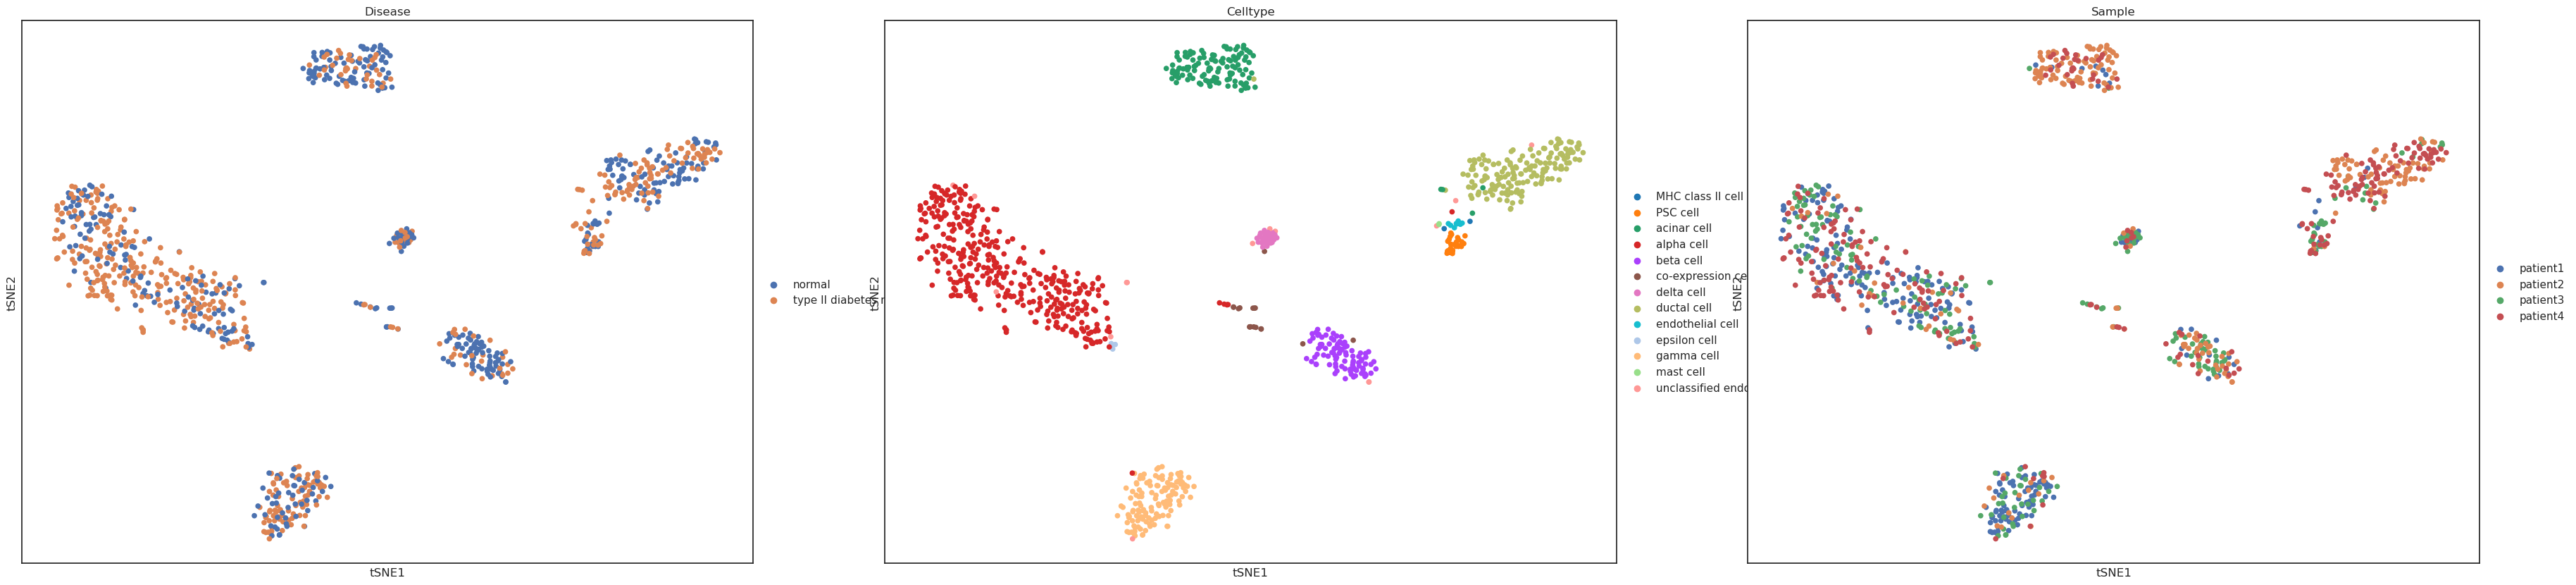

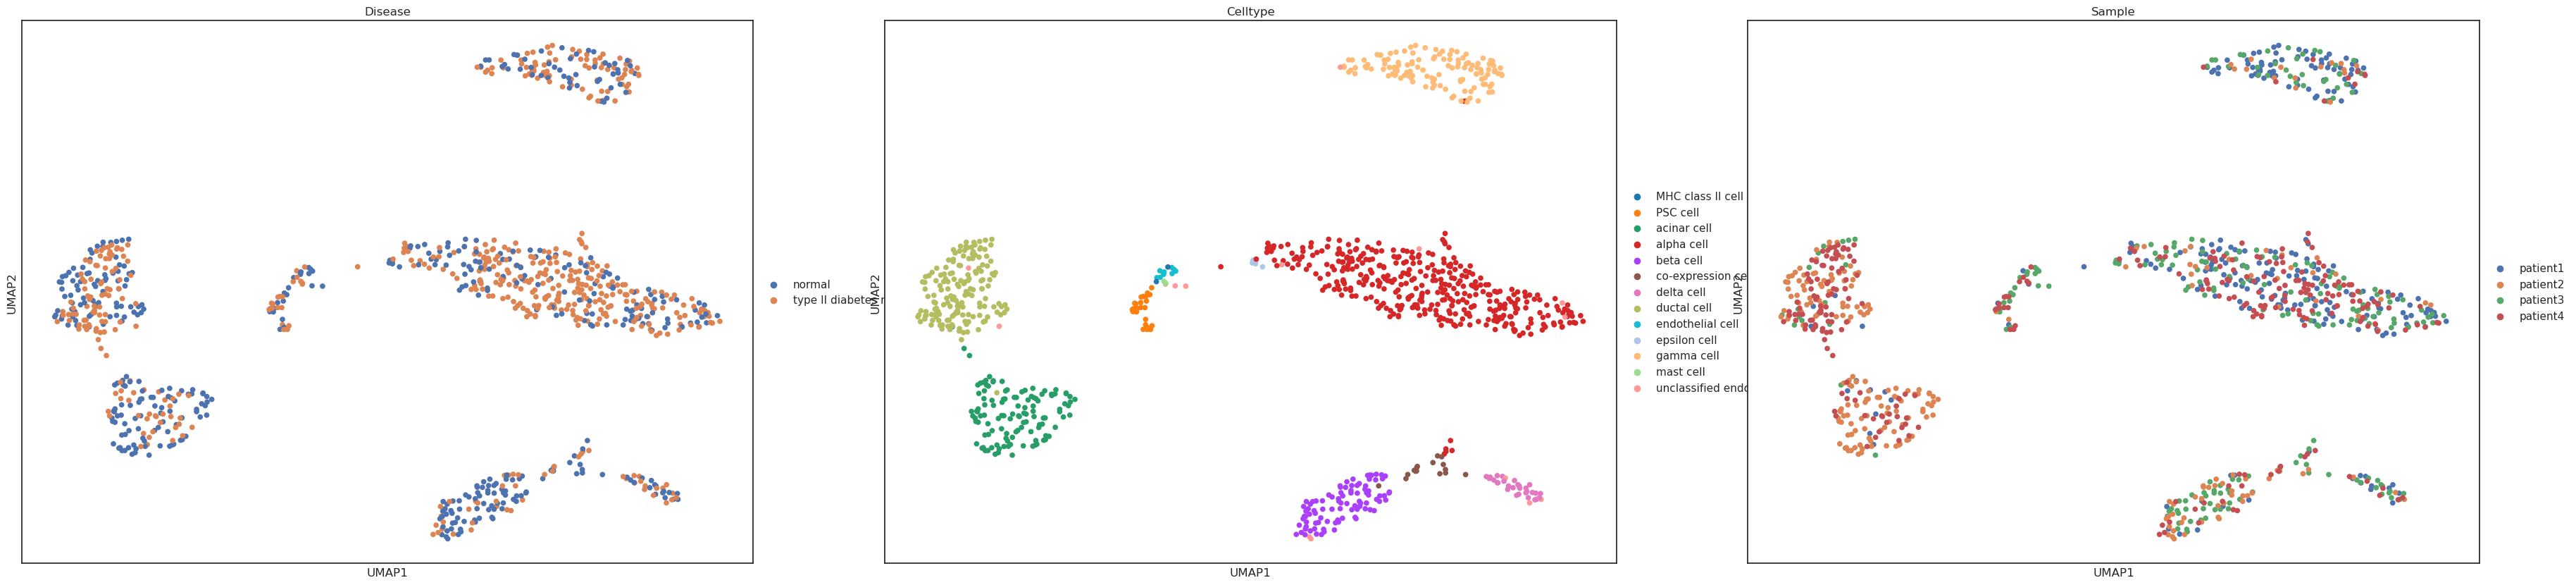

In [38]:
sc.pp.neighbors(sc_train_pp, n_neighbors=10, method='umap')
sc.tl.umap(sc_train_pp)
sc.tl.tsne(sc_train_pp)
sc.pl.tsne(sc_train_pp, color=["Disease", "Celltype", "Sample"])
sc.pl.umap(sc_train_pp, color=["Disease", "Celltype", "Sample"])

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


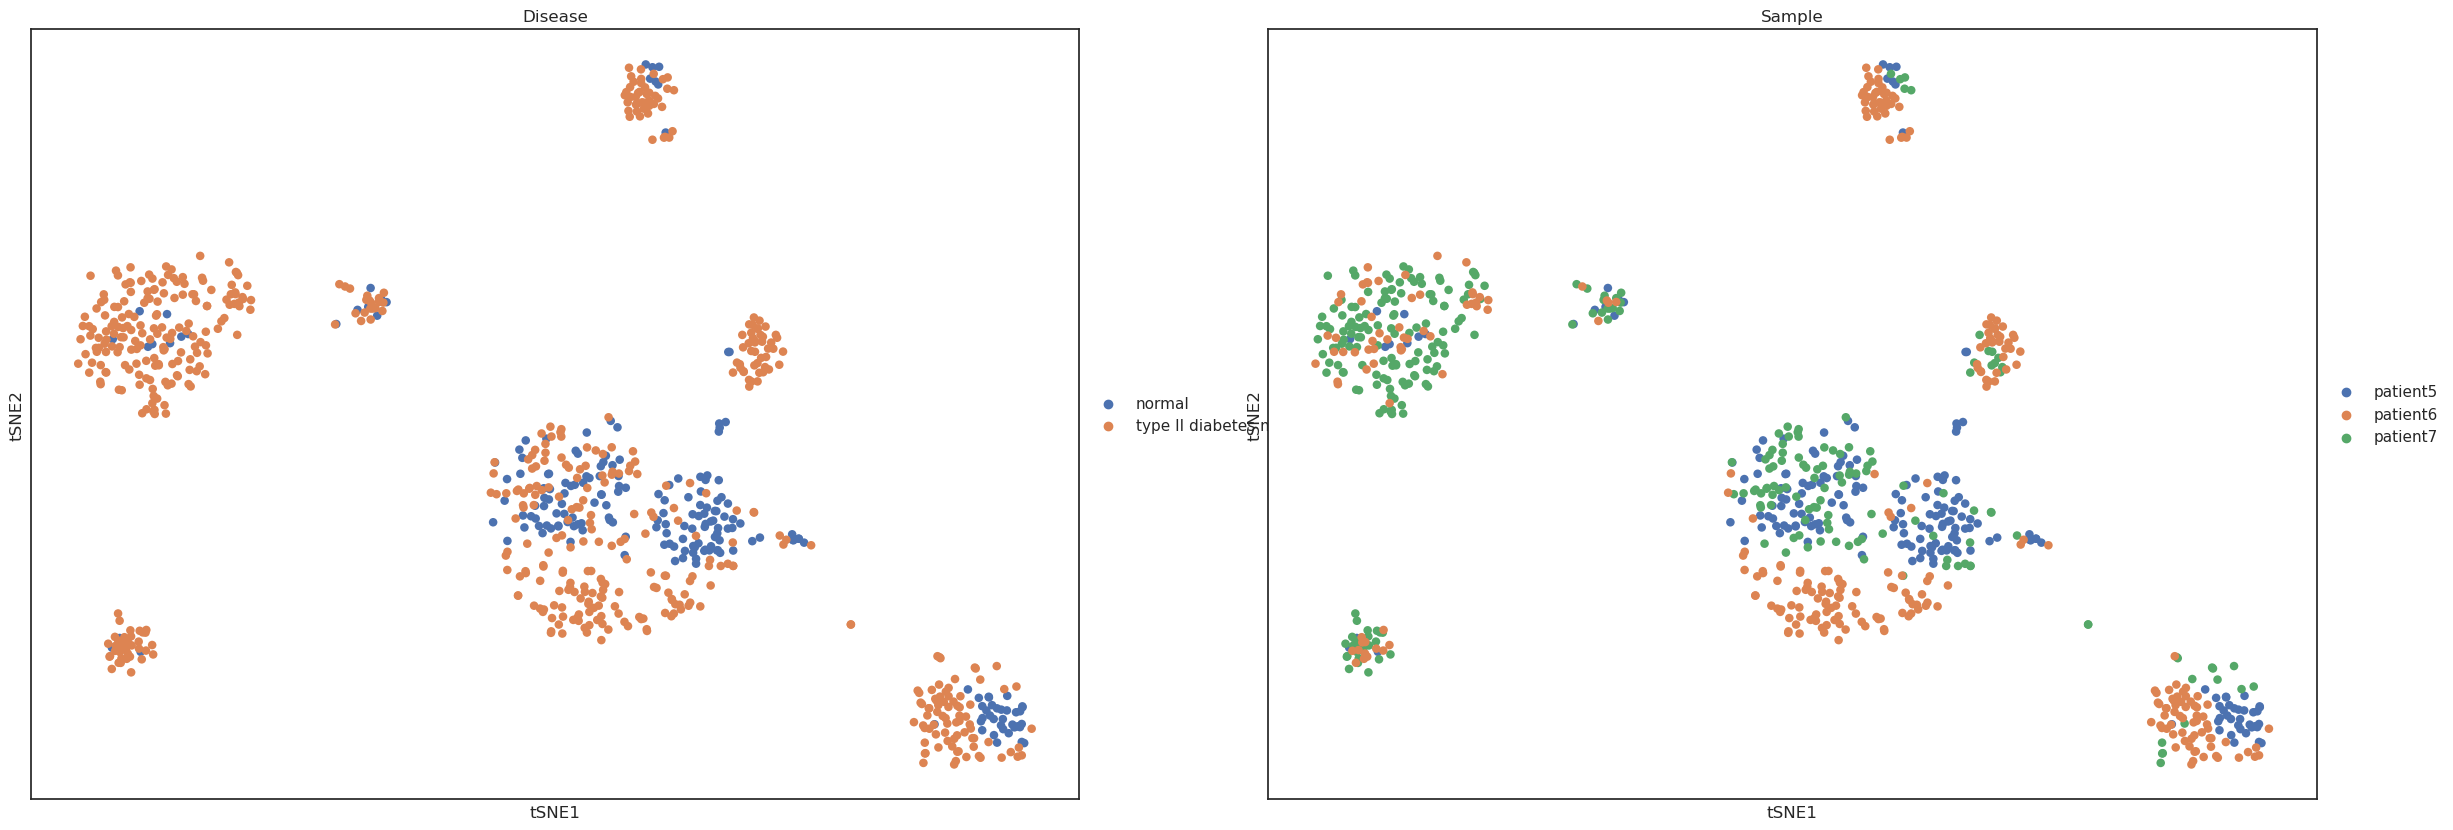

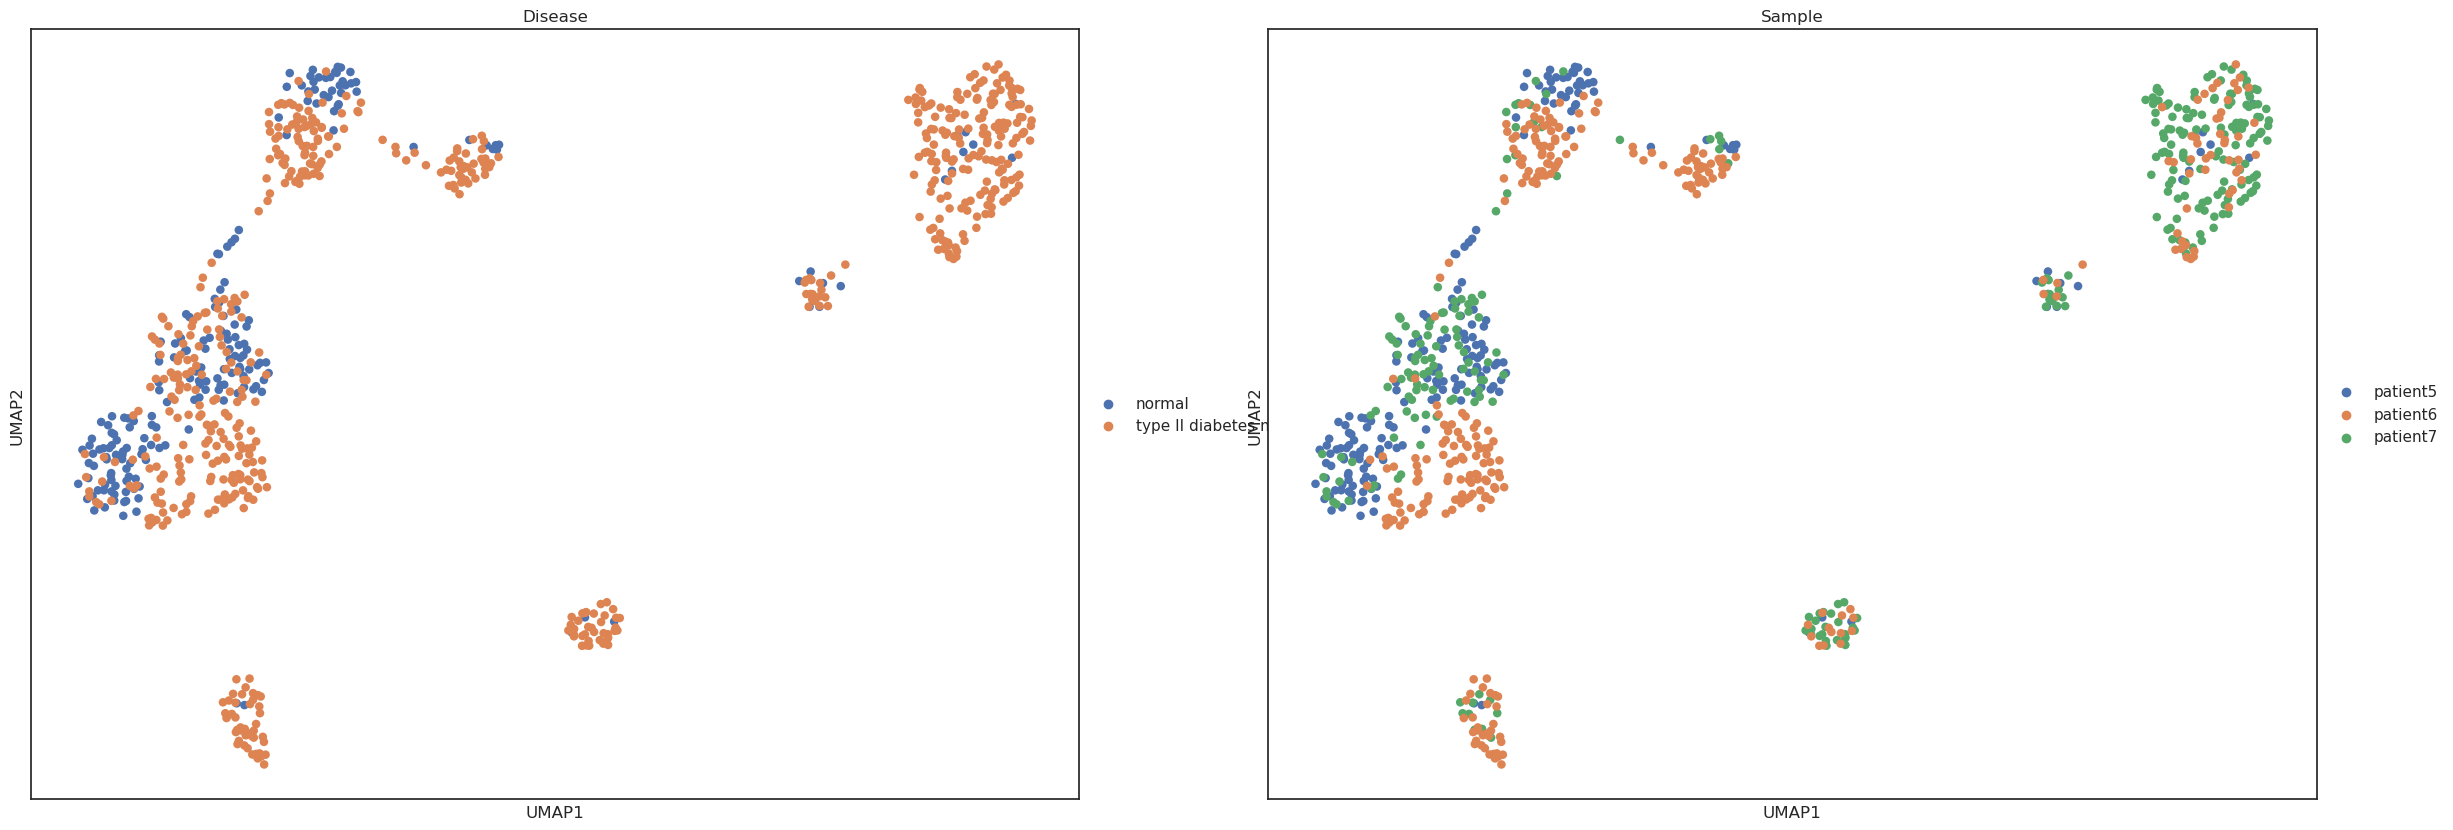

In [7]:
sc.pp.neighbors(sc_test_pp, n_neighbors=20, method='umap')
sc.tl.umap(sc_test_pp)
sc.tl.tsne(sc_test_pp)
sc.pl.tsne(sc_test_pp, color=["Disease", "Sample"])
sc.pl.umap(sc_test_pp, color=["Disease", "Sample"])

## 4. Perform Clustering

In [93]:
#Functions for clustering
def print_scores(pca_matrix, labels, labels_true):
    """
    Print various scores
    """
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    print(f"V-measure: {v_score:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    print(f"Silhouette Coefficient: {silhouette_score:.3f}")
    print(f"Overall Clustering Score: {1/3*(v_score+ari_score+silhouette_score)}")

def get_clustering_score(pca_matrix, labels, labels_true):
    """
    Return clustering score
    """
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    return 1/3*(v_score+ari_score+silhouette_score)

def get_silhouette_score(pca_matrix, labels):
    return metrics.silhouette_score(pca_matrix, labels)


In [150]:
def apply_kmeans(data, labels_true, n_clusters, plot = True, print_score = True, test = False):
    lowd_data_c = umap.UMAP(random_state=42, n_components = 200).fit_transform(data)
    lowd_data = PCA(n_components=50).fit_transform(lowd_data_c)

    KMean= KMeans(n_clusters=n_clusters, max_iter=500)
    KMean.fit(lowd_data_c)
    labels = KMean.predict(lowd_data_c)
    

    if print_score and not test:
        print_scores(lowd_data, labels, metadata_train["Celltype"])

    if plot:
        standard_embedding = umap.UMAP(random_state=42).fit_transform(data)
        plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

    if test == True:
        return get_silhouette_score(lowd_data, labels)
    
    else:
        return get_clustering_score(lowd_data, labels, labels_true)
    
def apply_louvain(adata,
                  pca_path, 
                  cluster_path,
                  n_neighbors = 20, 
                  n_components_umap = 100,
                  resolution = 0.25,
                  plot = True, 
                  print_score = True, 
                  test = False,
                  store_pca_ = True,
                  store_clustering = True):
    
    #Compute neighbor graph
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, method='umap', use_rep='X')

    if plot:
        sc.tl.umap(adata)

    #Get PCA for silhouette score
    lowd_umap = umap.UMAP(random_state=42, n_components = n_components_umap).fit_transform(adata.X)
    pca = PCA(n_components=50).fit_transform(lowd_umap)

    #Find communities
    sc.tl.leiden(adata, resolution=resolution)

    #Extract results
    labels = adata.obs['leiden'].to_list()
    if not test:
        labels_true = adata.obs['Celltype'].to_list()

    #Plot results
    if plot and not test:
        sc.pl.umap(adata, color=["Celltype", "leiden"])
        sc.pl.umap(adata, color=["Disease", "Sample"])
    if plot and test:
        sc.pl.umap(adata, color=["leiden", "Disease", "Sample"])

    #Print scores
    if print_score and not test:
        print_scores(pca, labels, labels_true)

    #Store pca if wished
    if store_pca_:
        pca_df = pd.DataFrame(pca, columns=["PC"+str(i) for i in range(1,51)])
        pca_df.insert(0, "index", adata.obs_names)
        pca_df.to_csv(pca_path, index=True)

    if store_clustering:
        cluster_df = pd.DataFrame(labels, columns=["cluster"])
        cluster_df.insert(0, "index", adata.obs_names)
        cluster_df.to_csv(cluster_path, index=True)

    #Return scores
    if test == True:
        return get_silhouette_score(pca, labels)
    
    else:
        return get_clustering_score(pca, labels, labels_true)

In [ ]:

#apply clustering algorithms on training set
apply_louvain(sc_train_pp, "j", "j", 
              resolution = 0.75, 
              plot = True, 
              n_components_umap = 100, 
              store_pca_=False, 
              store_clustering=False)

/home/mike/anaconda3/envs/eth_ml4g/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


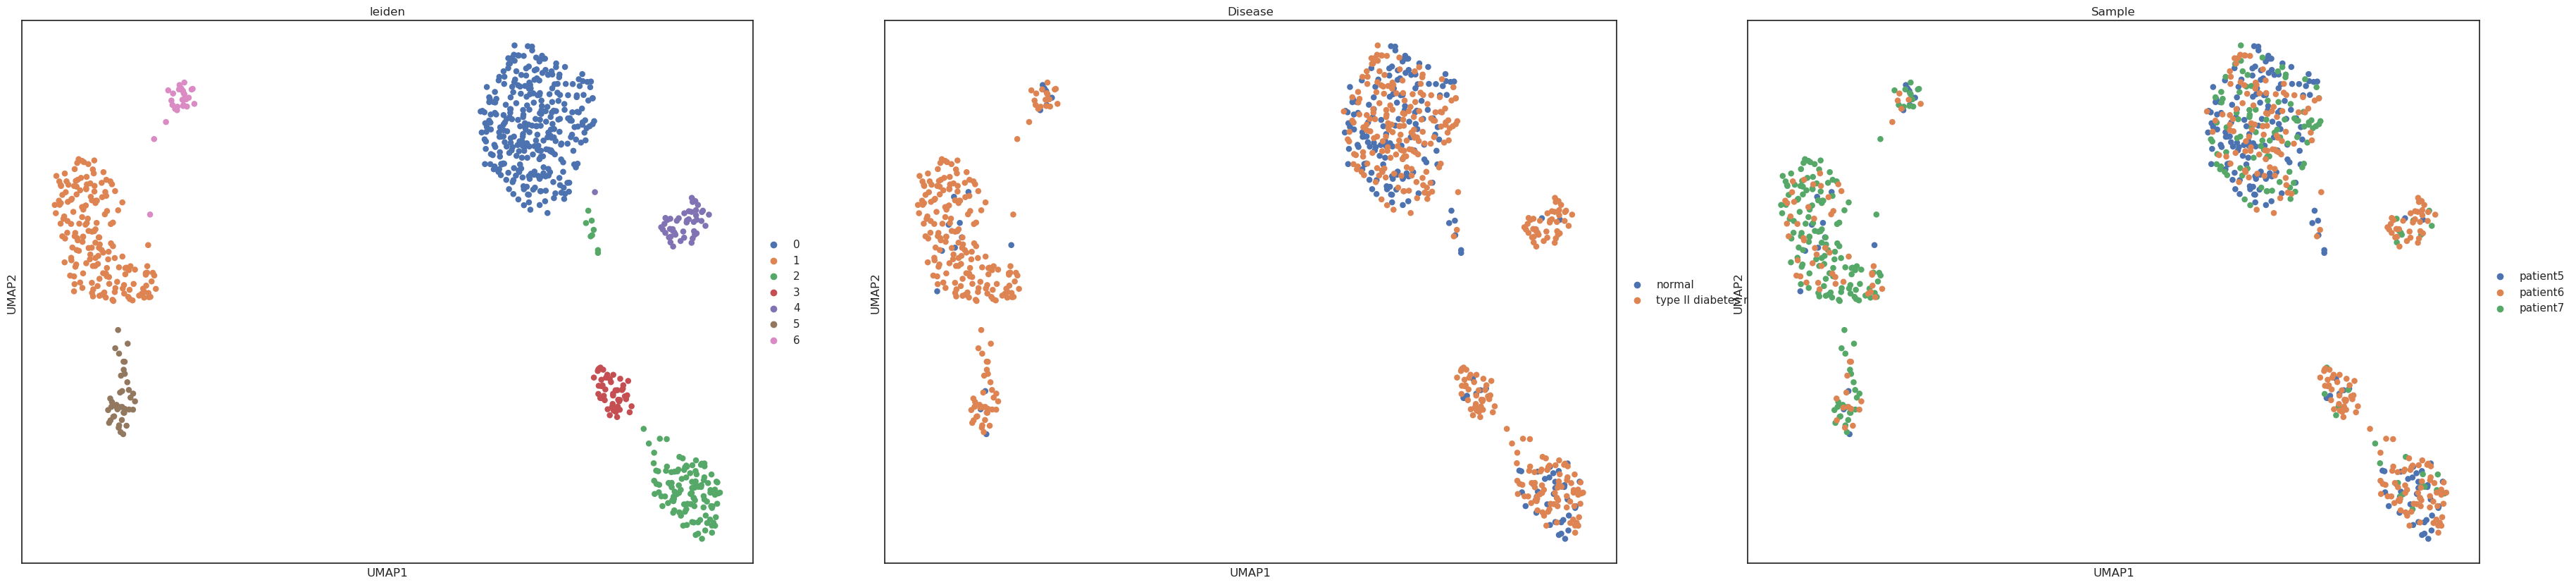

0.8409328

In [149]:
#apply clustering on test set
apply_louvain(sc_test_pp, 
              path_submission + "/PCA.csv", 
              path_submission + "/cluster_membership.csv",
              resolution = 0.75, 
              n_neighbors=20,
              plot=True, 
              test=True)